In [132]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import numba
import cv2

In [119]:
image = np.asarray(Image.open('test_img.jpg'))
image_1 = np.asarray(Image.open('test_img_1.jpg'))

In [140]:
def naive_filter(image, r):
    img = np.pad(image, [[r//2, r//2], [r//2, r//2], [0, 0]])
    result = np.zeros_like(img)
    for i in range(img.shape[0] - r + 1):
        for j in range(img.shape[1] - r + 1):
            window = img[i:i+r,j:j+r]
            result[i + r//2 + r%2, j + r//2 + r%2, :] = np.sort(window.reshape(r**2, img.shape[-1]), axis=0)[r**2//2]
    return result[r//2 + 1:-r//2, r//2 + 1:-r//2, :]

Наивный алгоритм:

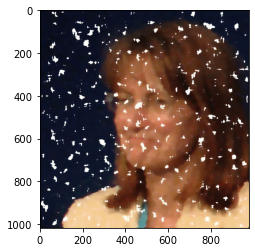

In [141]:
plt.imshow(naive_filter(image, 21))

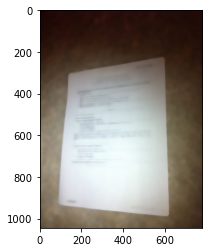

In [142]:
plt.imshow(naive_filter(image_1, 21))

In [143]:
@numba.njit
def huang_filter(img, r):
    def find_hists_medians(hists):
        result = []
        for hist in hists:
            tmp = np.cumsum(hist)
            result.append(np.where(tmp >= tmp[-1] // 2)[0][0])
        return np.array(result)
                    
    result = np.zeros_like(img)
    hists = None
    for i in range(img.shape[0] - r + 1):
        for j in range(img.shape[1] - r + 1):
            if j == 0:
                hists = []
                for k in range(img.shape[-1]):
                    hists.append(np.histogram(img[i:i + r, j:j + r, k], bins=256, range=(0, 256))[0])                
            else:
                for k in range(img.shape[-1]):
                    hists[k] -= np.histogram(img[i:i + r, j - 1, k], bins=256, range=(0, 256))[0]
                    hists[k] += np.histogram(img[i:i + r, j + r - 1, k], bins=256, range=(0, 256))[0]
            
            result[i + r//2 + r%2, j + r//2 + r%2, :] = find_hists_medians(hists)
            
    return result

Более эффективная реализация:

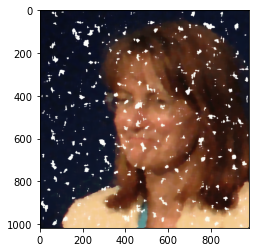

In [144]:
r = 21
plt.imshow(huang_filter(np.pad(image, [[r//2, r//2], [r//2, r//2], [0, 0]]), r)[r//2 + 1:-r//2, r//2 + 1:-r//2, :])

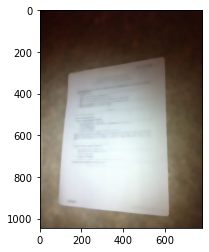

In [145]:
r = 21
plt.imshow(huang_filter(np.pad(image_1, [[r//2, r//2], [r//2, r//2], [0, 0]]), r)[r//2 + 1:-r//2, r//2 + 1:-r//2, :])

In [146]:
@numba.njit
def constant_filter(img, r):
    def find_hists_medians(hists):
        result = []
        for hist in hists:
            tmp = np.cumsum(hist)
            result.append(np.where(tmp >= tmp[-1] // 2)[0][0])
        return np.array(result)
                    
    result = np.zeros_like(img)
    hists = None
    column_hists = [
        [np.histogram(img[:r, j, 0], bins=256, range=(0, 256))[0] for j in range(img.shape[1])]
        for k in range(img.shape[-1])
    ] # #инициализация гистограмм столбцов       
            
    for i in range(img.shape[0] - r + 1):
        if i > 0: #обновляем гистограммы столбцов
            for j in range(img.shape[1]):
                for k in range(img.shape[-1]):
                    column_hists[k][j][img[i - 1, j, k]] -= 1
                    column_hists[k][j][img[i + r - 1, j, k]] += 1
                    
        for j in range(img.shape[1] - r + 1):
            if j == 0:
                hists = []
                for k in range(img.shape[-1]):
                    hists.append(np.histogram(img[i:i + r, j:j + r, k], bins=256, range=(0, 256))[0])                
            else:
                for k in range(img.shape[-1]):
                    hists[k] -= column_hists[k][j - 1]
                    hists[k] += column_hists[k][j + r - 1]
            
            result[i + r//2 + r%2, j + r//2 + r%2, :] = find_hists_medians(hists)
            
    return result

Реализация за O(1):

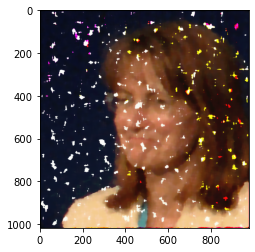

In [147]:
r = 21
plt.imshow(constant_filter(np.pad(image, [[r//2, r//2], [r//2, r//2], [0, 0]]), r)[r//2 + 1:-r//2, r//2 + 1:-r//2, :])

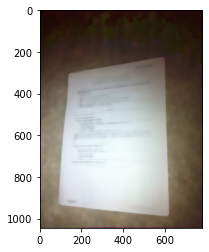

In [148]:
r = 21
plt.imshow(constant_filter(np.pad(image_1, [[r//2, r//2], [r//2, r//2], [0, 0]]), r)[r//2 + 1:-r//2, r//2 + 1:-r//2, :])

In [154]:
r_s = np.linspace(1, 49, 10).astype(int) * 2 + 1
img = np.zeros((1000, 1000, 3))
time_elapsed = [[], [], []]
for r in tqdm(r_s):
    time_start = time.time()
    naive_filter(img, r)
    time_finish = time.time()
    time_elapsed[0].append(time_finish - time_start)
    time_start = time.time()
    huang_filter(np.pad(image, [[r//2, r//2], [r//2, r//2], [0, 0]]), r)
    time_finish = time.time()
    time_elapsed[1].append(time_finish - time_start)
    time_start = time.time()
    constant_filter(np.pad(image, [[r//2, r//2], [r//2, r//2], [0, 0]]), r)
    time_finish = time.time()
    time_elapsed[2].append(time_finish - time_start)

  0%|          | 0/10 [00:00<?, ?it/s]

Как можно увидеть, резуальтаты визуально совпадают

Время работы в логарифмической шкале:

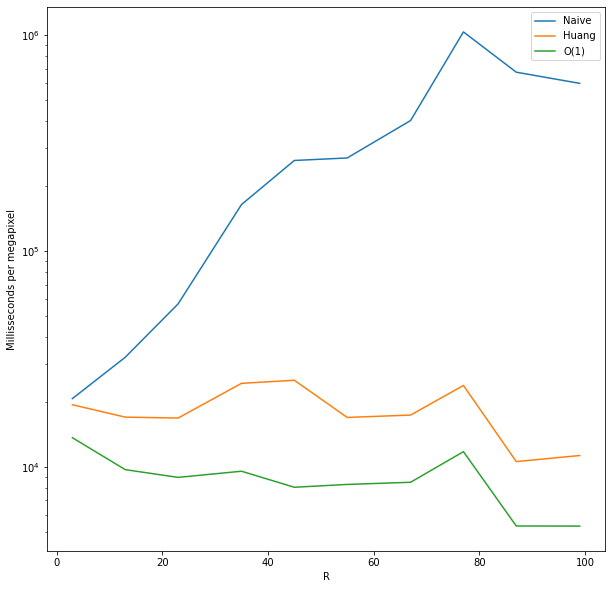

In [155]:
plt.figure(figsize=(10, 10))
plt.xlabel('R')
plt.ylabel('Millisseconds per megapixel')
plt.yscale('log')
plt.plot(r_s, [i * 1000 for i in time_elapsed[0]], label='Naive')
plt.plot(r_s, [i * 1000 for i in time_elapsed[1]], label='Huang')
plt.plot(r_s, [i * 1000 for i in time_elapsed[2]], label='O(1)')
plt.legend()
plt.show()

Судя по графикам, даже при малых размерах окна не стоит строить какую-либо композицию, а стоит использовать наиболее эффективную реализацию

Наивная реализация имеет сложность $O(WHR^2log{R})$ и требует $O(R^2)$ памяти на хранение окна <br>
Более эффективная реализация имеет сложность $O(WH(R+N))$ и требует $O(1)$ памяти на хранение гистограмм <br>
Реализация за константное время имеет сложность $O(WH)$ и требует $O(RW)$ памяти на хранение гистограмм стобцов <br>

Сравнение с OpenCV:

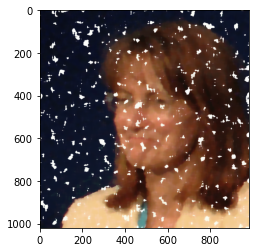

In [138]:
plt.imshow(cv2.medianBlur(image, 21))

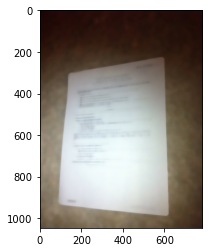

In [149]:
plt.imshow(cv2.medianBlur(image_1, 21))

In [161]:
time_elapsed_cv = []
for r in tqdm(r_s):
    time_start = time.time()
    cv2.medianBlur(img.astype(np.uint8), r)
    time_finish = time.time()
    time_elapsed_cv.append(time_finish - time_start)

  0%|          | 0/10 [00:00<?, ?it/s]

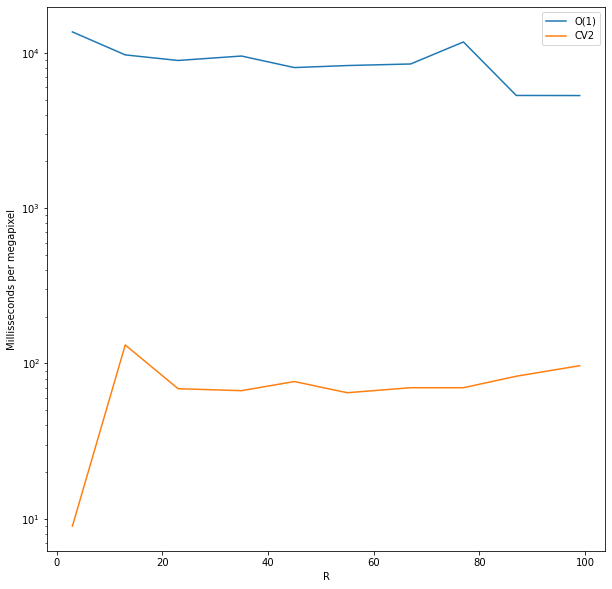

In [163]:
plt.figure(figsize=(10, 10))
plt.xlabel('R')
plt.ylabel('Millisseconds per megapixel')
plt.yscale('log')
plt.plot(r_s, [i * 1000 for i in time_elapsed[2]], label='O(1)')
plt.plot(r_s, [i * 1000 for i in time_elapsed_cv], label='CV2')
plt.legend()
plt.show()

Визуально результат такой же, но работает готовая реализация быстрее